In [2]:
import numpy as np
import pandas as pd
import json
import io
import os
import sys
import pickle
import math
import random

import matplotlib.pyplot as plt

In [3]:
def EMD(Z_i, Z_global):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))


In [1]:
NO_CLIENTS = 56
NO_GROUPS = 7
NO_CLASSES = 10
ALPHA = "03"

replace_dict = {
    0: 7,
    1: 6,
    2: 5,
    3: 4,
    4: 3,
    5: 2,
    6: 1,
}

In [4]:
path = f"../data/32_Cifar10_NIID_{NO_CLIENTS}c_a{ALPHA}/config.json"
conf = json.loads(open(path, "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

main_label_vectors = np.zeros((NO_CLIENTS,NO_CLASSES))
for client_id in range(NO_CLIENTS):
    for class_id in range(NO_CLASSES):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]

In [5]:
weak    = 2_500_000 
# normal1 = 15_000_000
normal = 35_000_000
# normal1 = 80_000_000
# normal2 = 80_000_000
strong  = 80_000_000

bw_types = (["low"]*10) + (["medium"]*36) + (["high"]*10)

lows = [weak] * 10
mediums = [normal] * 36
highs = [strong] * 10
bw = lows + mediums + highs

ids = np.arange(NO_CLIENTS)
random.shuffle(ids)

bws = []
for idx in ids:
    bws.append((bw[idx],bw_types[idx]))

In [6]:
clients_list = []
for idx in range(len(main_label_vectors)):
    clients_list.append(
        {
            "client_id" : idx,
            "bw" : bws[idx][0],
            "bw_type" : bws[idx][1],
            "distribution" : main_label_vectors[idx],
            "group" : None
        }
    )

In [7]:
clients_df = pd.DataFrame(clients_list)
clients_df.head()

,client_id,bw,bw_type,distribution,group
0,0,35000000,medium,"[342.0, 10.0, 537.0, 177.0, 70.0, 0.0, 0.0, 0....",None
1,1,35000000,medium,"[6.0, 6.0, 309.0, 1510.0, 0.0, 0.0, 0.0, 0.0, ...",None
2,2,35000000,medium,"[346.0, 0.0, 128.0, 77.0, 189.0, 431.0, 0.0, 0...",None
3,3,35000000,medium,"[14.0, 231.0, 2.0, 254.0, 1.0, 9.0, 79.0, 1021...",None
4,4,35000000,medium,"[75.0, 468.0, 389.0, 0.0, 2.0, 69.0, 939.0, 0....",None


In [8]:
maindf = clients_df.sort_values("bw")

In [9]:
maindf["group"] = np.repeat(np.arange(7),8)

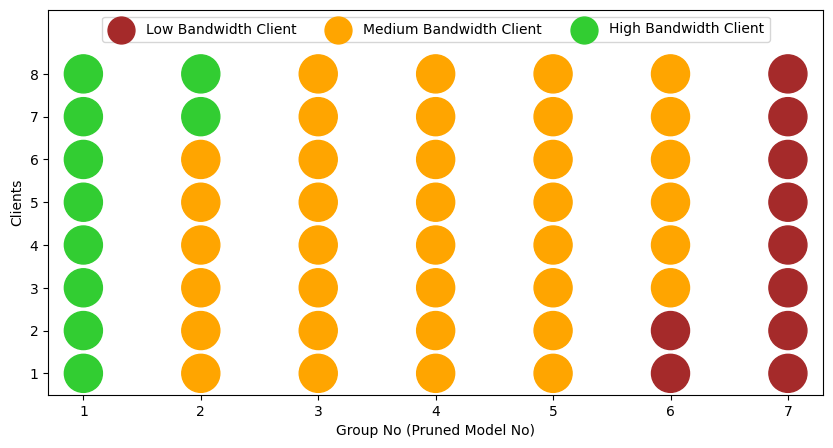

In [100]:
maindf = pd.read_csv("../data/bws_groups.csv", index_col=0)

for idx,row in maindf.iterrows():
    maindf.at[idx,"group"] = replace_dict[row.group]
    maindf.at[idx,"distribution"] = np.array([float(item) for item in row.distribution.replace("[","").replace("]","").split(" ") if item != ""])

def vis_bw_counts(maindf):
    # bw_counts = {
    #     "low" : [],
    #     "medium" : [],
    #     "high" : []
    # }
    # for group_name, group_df in maindf.groupby("group"):
    #     group_dict = group_df.groupby("bw_type").count()["client_id"].to_dict()
    #     for key, value in bw_counts.items():
    #         try:
    #             bw_counts[key].append(group_dict[key])
    #         except:
    #             bw_counts[key].append(0)

    # bw_counts

    # fig, ax = plt.subplots()

    # ax.bar(np.arange(NO_GROUPS), bw_counts["low"], label="low")
    # ax.bar(np.arange(NO_GROUPS), bw_counts["medium"], label="medium", bottom=np.array(bw_counts["low"]))
    # ax.bar(np.arange(NO_GROUPS), bw_counts["high"], label="high", bottom=np.array(bw_counts["low"]) + np.array(bw_counts["medium"]))
    # plt.legend()
    # plt.show()

    x = np.array(np.meshgrid(np.arange(1,8),np.arange(1,9))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(1,8),np.arange(1,9))).T.reshape(-1,2)[:,1]
    s = np.ones((7,8))*600
    
    tiers = [[] for i in range(7)]
    for group_name, group_df in maindf.groupby("group"):
        tiers[group_name-1] = group_df["bw_type"].tolist()


    circle_size = 750
    s_low = []
    for group_no in range(7):
        s_low.append([])
        for client_no in range(8):
            tier = tiers[group_no][client_no]
            if tier == "low": size = circle_size
            else: size = 0
            s_low[group_no].append(size)

    s_medium = []
    for group_no in range(7):
        s_medium.append([])
        for client_no in range(8):
            tier = tiers[group_no][client_no]
            if tier == "medium": size = circle_size
            else: size = 0
            s_medium[group_no].append(size)

    s_high = []
    for group_no in range(7):
        s_high.append([])
        for client_no in range(8):
            tier = tiers[group_no][client_no]
            if tier == "high": size = circle_size
            else: size = 0
            s_high[group_no].append(size)


    plt.figure(figsize=(10,5))
    plt.scatter(x, y, s_low,    c="brown",      label="Low Bandwidth Client")
    plt.scatter(x, y, s_medium, c="orange",     label="Medium Bandwidth Client")
    plt.scatter(x, y, s_high,   c="limegreen",  label="High Bandwidth Client")
    plt.legend(loc="upper center", ncol=3)
    plt.ylim(0.5,9.5)
    plt.yticks(np.arange(1,9))
    plt.xlabel("Group No (Pruned Model No)")
    plt.ylabel("Clients")
    plt.show()

vis_bw_counts(maindf)

In [101]:
#maindf.to_csv("../data/32_Cifar10_NIID_56c_a03/bws_groups.csv")
maindf.head()

,client_id,bw,bw_type,distribution,group
0,0,2500000,low,"[342.0, 10.0, 537.0, 177.0, 70.0, 0.0, 0.0, 0....",7
33,33,2500000,low,"[450.0, 7.0, 7.0, 9.0, 1.0, 69.0, 3.0, 900.0, ...",7
34,34,2500000,low,"[0.0, 28.0, 3.0, 44.0, 33.0, 1.0, 10.0, 114.0,...",7
17,17,2500000,low,"[0.0, 12.0, 163.0, 27.0, 109.0, 1.0, 134.0, 14...",7
37,37,2500000,low,"[193.0, 0.0, 414.0, 3.0, 83.0, 48.0, 87.0, 133...",7


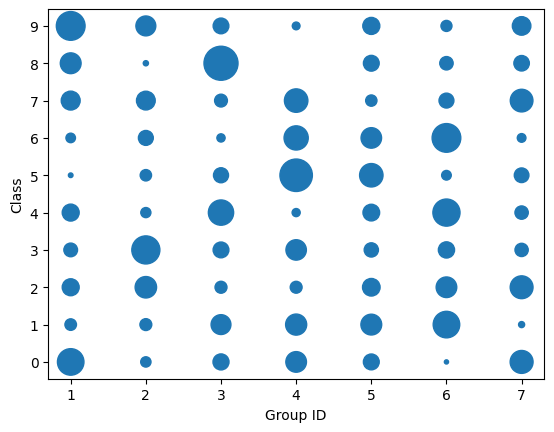

In [102]:
def vis_group_dist(df):

    class_dist = []
    for group_name, group_df in df.groupby("group"):
        class_dist.append(np.sum(group_df.distribution.tolist(),axis=0))
    
    class_dist = np.array(class_dist)

    x = np.array(np.meshgrid(np.arange(1,8),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(1,8),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
    s = class_dist.reshape(1,-1)[0]
    s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*600).astype("int")
    plt.scatter(x,y,s)
    plt.yticks(np.arange(10))
    plt.xlabel("Group ID")
    plt.ylabel("Class")
    plt.show()
    

vis_group_dist(maindf)


In [103]:
for iter_no in range(20):
    print(round(0.90**(iter_no+1),2))

0.9
0.81
0.73
0.66
0.59
0.53
0.48
0.43
0.39
0.35
0.31
0.28
0.25
0.23
0.21
0.19
0.17
0.15
0.14
0.12


0.40426950298597936 0.5031965494114675
0.49050913860939 0.5031965494114675
0.38427808161882143 0.40255723952917405
0.36969191004373436 0.40255723952917405
0.40426950298597936 0.5031965494114675
0.49050913860939 0.5031965494114675
0.38427808161882143 0.40255723952917405
0.36969191004373436 0.40255723952917405
0.40426950298597936 0.5031965494114675
0.49050913860939 0.5031965494114675
0.38427808161882143 0.40255723952917405
0.36969191004373436 0.40255723952917405
0.40426950298597936 0.5031965494114675
0.49050913860939 0.5031965494114675
0.38427808161882143 0.40255723952917405
0.36969191004373436 0.40255723952917405
0.40426950298597936 0.5031965494114675
0.49050913860939 0.5031965494114675
0.38427808161882143 0.40255723952917405
0.36969191004373436 0.40255723952917405
0.40426950298597936 0.5031965494114675
0.49050913860939 0.5031965494114675
0.38427808161882143 0.40255723952917405
0.36969191004373436 0.40255723952917405
0.40426950298597936 0.5031965494114675
0.49050913860939 0.503196549411

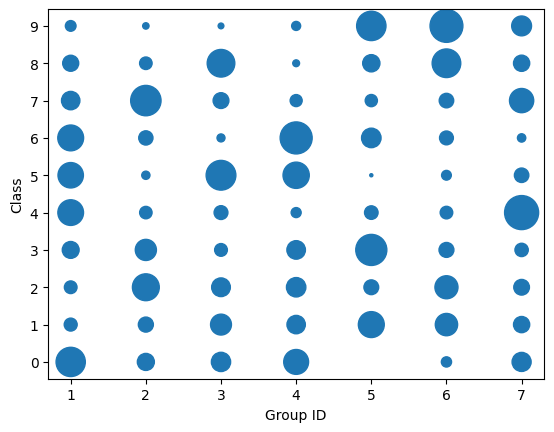

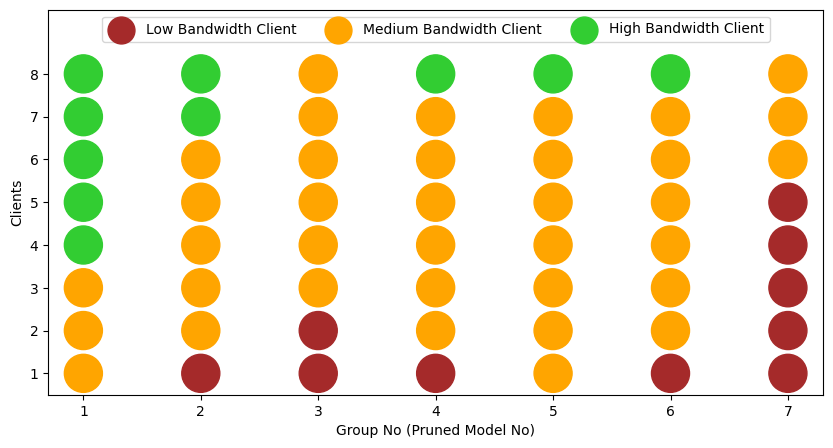

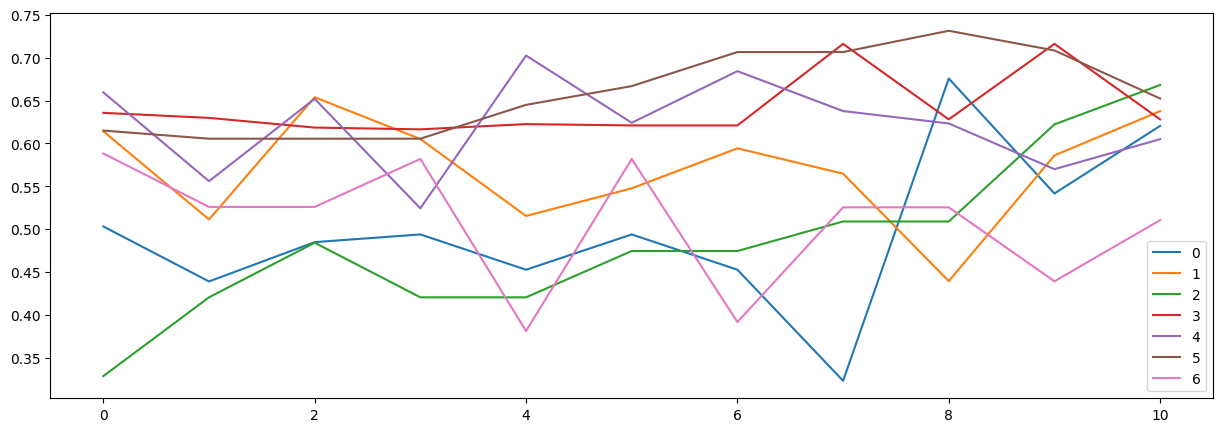

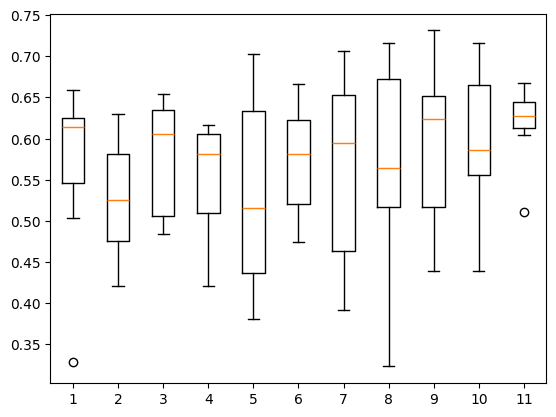

In [46]:
global_dist = np.sum(maindf.distribution.values, axis=0)

df_iter = maindf.copy()

COEFF = 0.8
all_scores = []

scores = []
for group_no in range(NO_GROUPS,0,-1):
    group_selected = df_iter[df_iter["group"] == group_no]
    group_dist = np.sum(group_selected.distribution.values, axis=0)
    scores.append(EMD(group_dist, global_dist))
all_scores.append(scores)

for iter_no in range(10):
    no_operations_done = 0
    for group_no in range(NO_GROUPS,0,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        
        group_friend_next = df_iter[df_iter["group"] == group_no-1]
        group_friend_prev = df_iter[df_iter["group"] == group_no+1]

        group_friend_next_2 = df_iter[df_iter["group"] == group_no-2]
        group_friend_prev_2 = df_iter[df_iter["group"] == group_no+2]

        candidate_groups = [
            group_friend_next,
            group_friend_prev,
            group_friend_next_2,
            group_friend_prev_2
            ]

        

        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        score = EMD(group_dist, global_dist)
        candidate_operations = []
        for idx, row in group_selected.iterrows():
            client_id = row.client_id
            group_dist_wo = group_dist - np.array(row.distribution)
            bw_type = row.bw_type

            for candidate_group in candidate_groups:
                for idx2, row2 in candidate_group.iterrows():
                    candidate_dist = group_dist + np.array(row2.distribution)
                    candidate_score = EMD(candidate_dist ,global_dist)
                    bw_type_candidate = row2.bw_type
                    if bw_type == bw_type_candidate: coeff = 1
                    else: coeff = COEFF**(iter_no+1)
                    if candidate_score < score*coeff:
                        print(candidate_score, score*coeff)
                        candidate_operations.append((client_id, row2.client_id, candidate_score))
        # Transfer operation            
        candidate_operations = np.array(candidate_operations)
        if len(candidate_operations) > 0:
            selected_idx = np.argmin(candidate_operations[:,2])
            selected_operation = candidate_operations[selected_idx]
            # print(selected_operation)
            df_dict = df_iter.to_dict(orient="index")
            main_group = df_dict[selected_operation[0]]["group"]
            other_group = df_dict[selected_operation[1]]["group"]
            # print((main_group, other_group))

            df_iter.at[selected_operation[0], "group"] = other_group
            df_iter.at[selected_operation[1], "group"] = main_group
            no_operations_done += 1

    scores = []
    for group_no in range(NO_GROUPS,0,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        scores.append(EMD(group_dist, global_dist))
    all_scores.append(scores)

    print("No operations done :",no_operations_done)
vis_group_dist(df_iter)
vis_bw_counts(df_iter)

### EMD CHANGE
all_scores = np.array(all_scores)
ax = plt.subplots(figsize=(15,5))
for group_no in range(NO_GROUPS):
    plt.plot(all_scores[:,group_no], label=group_no)
plt.legend()
plt.show()
plt.boxplot(all_scores.T)
plt.show()

[2, 3, 4, 5, 6, 7, 1]
[1.         9.         0.50873283] ('high', 'medium')
[11.         36.          0.47586437] ('medium', 'medium')
[ 5.         20.          0.45668434] ('medium', 'medium')
[38.         33.          0.44223712] ('medium', 'low')
[ 4.         37.          0.41482549] ('low', 'low')
[ 0.         48.          0.40326363] ('low', 'medium')
[49.         15.          0.37731954] ('high', 'medium')
############ ITER 0
No operations done : 7
[3, 4, 5, 6, 7, 1, 2]
[26.         24.          0.36499632] ('medium', 'medium')
[39.         28.          0.33711998] ('medium', 'medium')
[ 0.         44.          0.32197736] ('low', 'medium')
[25.         37.          0.32075145] ('low', 'low')
[30.         13.          0.30449113] ('high', 'medium')
[23.          7.          0.30131442] ('medium', 'medium')
############ ITER 1
No operations done : 6
[4, 5, 6, 7, 1, 2, 3]
[23.         55.          0.28773269] ('medium', 'medium')
[54.         26.          0.28299353] ('medium', 'me

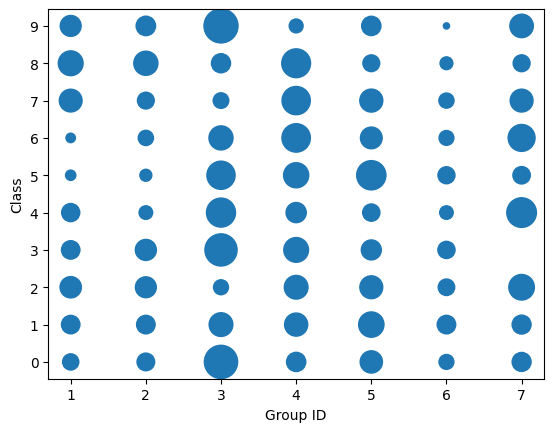

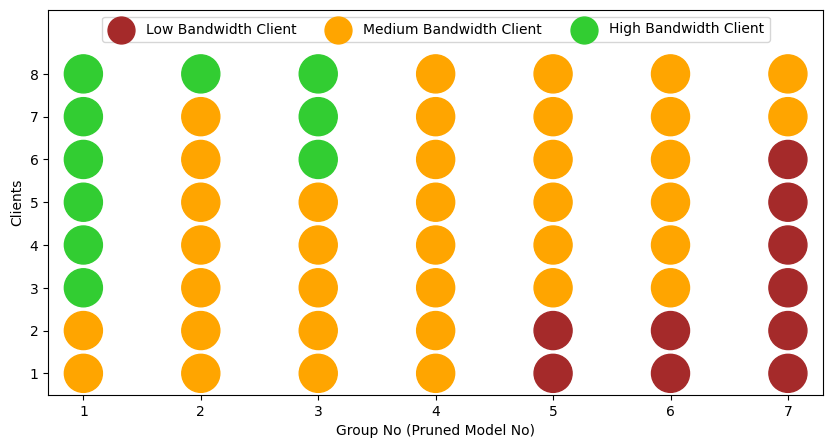

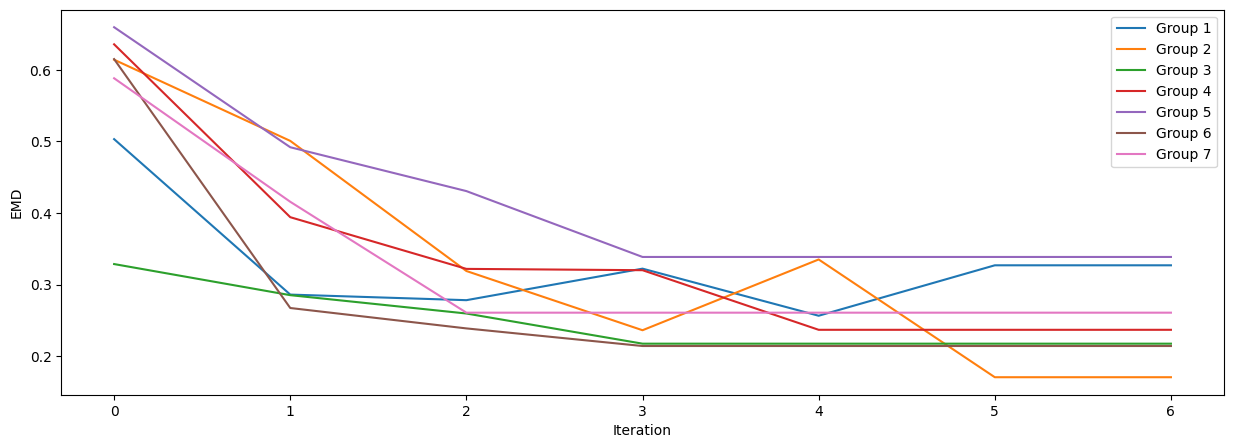

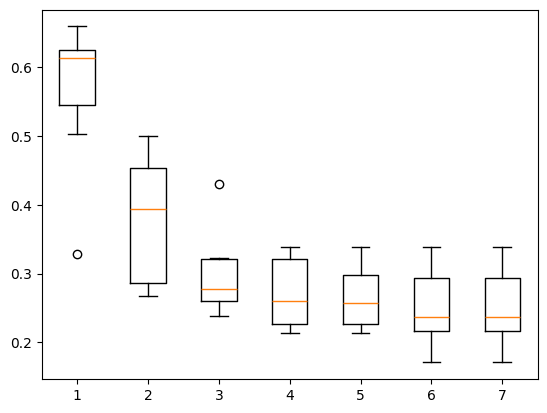

In [122]:
def transfer_op(df_iter, candidate_operations, selected_idx):
    selected_operation = candidate_operations[selected_idx]

    df_dict = df_iter.to_dict(orient="index")
    main_group = df_dict[selected_operation[0]]["group"]
    other_group = df_dict[selected_operation[1]]["group"]

    df_iter.at[selected_operation[0], "group"] = other_group
    df_iter.at[selected_operation[1], "group"] = main_group

    return df_iter

def average_EMD(df_iter, global_dist):
    EMDs = []
    for group_name, group_df in df_iter.groupby("group"):
        EMDs.append(EMD(np.sum(group_df.distribution.values, axis=0), global_dist))
    return np.mean(EMDs)

global_dist = np.sum(maindf.distribution.values, axis=0)
df_iter = maindf.copy()

COEFF = 0.9
all_scores = []
scores = []
emds = []
for group_no in range(NO_GROUPS,0,-1):
    group_selected = df_iter[df_iter["group"] == group_no]
    group_dist = np.sum(group_selected.distribution.values, axis=0)
    scores.append(EMD(group_dist, global_dist))
all_scores.append(scores)


seq_of_move = np.arange(1,NO_GROUPS+1).tolist()

for iter_no in range(10):
    no_operations_done = 0
    # for group_no in range(NO_GROUPS,0,-1):
    # seq_of_move = sorted(np.arange(1,NO_GROUPS+1), key=lambda k: random.random())
    seq_of_move = seq_of_move[1:] + seq_of_move[: 1]
    print(seq_of_move)
    for group_no in seq_of_move:
        current_emd = average_EMD(df_iter, global_dist)
        group_selected = df_iter[df_iter["group"] == group_no]
        
        group_friend_next = df_iter[df_iter["group"] == group_no-1]
        group_friend_prev = df_iter[df_iter["group"] == group_no+1]

        group_friend_next_2 = df_iter[df_iter["group"] == group_no-2]
        group_friend_prev_2 = df_iter[df_iter["group"] == group_no+2]

        candidate_groups = [
            group_friend_next,
            group_friend_prev,
            group_friend_next_2,
            group_friend_prev_2
            ]

        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        score = EMD(group_dist, global_dist)
        candidate_operations = []
        bw_debug = []
        for idx, row in group_selected.iterrows():
            client_id = row.client_id
            group_dist_wo = group_dist - np.array(row.distribution)
            bw_type = row.bw_type

            for candidate_group in candidate_groups:
                for idx2, row2 in candidate_group.iterrows():
                    candidate_dist = group_dist_wo + np.array(row2.distribution)
                    candidate_score = EMD(candidate_dist ,global_dist)
                    bw_type_candidate = row2.bw_type
                    if bw_type == bw_type_candidate: coeff = 1
                    else:
                        # coeff = COEFF**(iter_no+1)
                        coeff = COEFF

                    if candidate_score < score*coeff:

                        df_iter_temp = transfer_op(df_iter.copy(), [(client_id, row2.client_id, candidate_score)], -1)
                        avg_emd = average_EMD(df_iter_temp, global_dist)
                        emds.append(avg_emd)

                        # candidate_operations.append((client_id, row2.client_id, candidate_score))
                        candidate_operations.append((client_id, row2.client_id, avg_emd))
                        bw_debug.append((bw_type, bw_type_candidate))


        # Transfer operation            
        candidate_operations = np.array(candidate_operations)
        if len(candidate_operations) > 0:
            selected_idx = np.argmin(candidate_operations[:,2])
            if current_emd > candidate_operations[selected_idx,2]:
                print(candidate_operations[selected_idx], bw_debug[selected_idx])
                df_iter = transfer_op(df_iter, candidate_operations, selected_idx)
                no_operations_done += 1

    scores = []
    for group_no in range(NO_GROUPS,0,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        scores.append(EMD(group_dist, global_dist))
    all_scores.append(scores)

    print(f"## ITER {iter_no} | No operations done : {no_operations_done}")
    if no_operations_done == 0:
        break

vis_group_dist(df_iter)
vis_bw_counts(df_iter)

### EMD CHANGE
all_scores = np.array(all_scores)
ax = plt.subplots(figsize=(15,5))
for group_no in range(NO_GROUPS):
    plt.plot(all_scores[:,group_no], label=f"Group {group_no+1}")
plt.xlabel("Iteration")
plt.ylabel("EMD")
plt.legend()
plt.show()

plt.boxplot(all_scores.T)
plt.show()

In [124]:
np.mean(all_scores[-1])

0.25225231363542594

In [93]:
# Initial tuple of tuples
tuple_of_tuples = ((1, 2, 3), (4, 5, 6), (7, 8, 9))

# Tuple to append
tuple_to_append = (10, 11, "12")

# Append the tuple to the tuple of tuples
new_tuple_of_tuples = tuple_of_tuples + (tuple_to_append,)

np.array(new_tuple_of_tuples)

array([['1', '2', '3'],
       ['4', '5', '6'],
       ['7', '8', '9'],
       ['10', '11', '12']], dtype='<U21')